In [20]:
import numpy as np

import matplotlib.pyplot as plt

import shap

import lightgbm as lgb

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification

In [21]:
# Generate dataset

X,y = make_classification(n_samples=5000, n_features=10, random_state=42)

In [22]:
# Split the Data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [23]:
# Train LightGBM model

train_data = lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test)

In [24]:
params = {

    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'learning_rate' : 0.05,
    'num_leaves' : 31

}

In [25]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=200,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=False)
    ]

    )

[LightGBM] [Info] Number of positive: 2017, number of negative: 1983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504250 -> initscore=0.017000
[LightGBM] [Info] Start training from score 0.017000
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.204884


In [26]:
# Calculate SHAP values

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

/opt/anaconda3/envs/masterxml/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


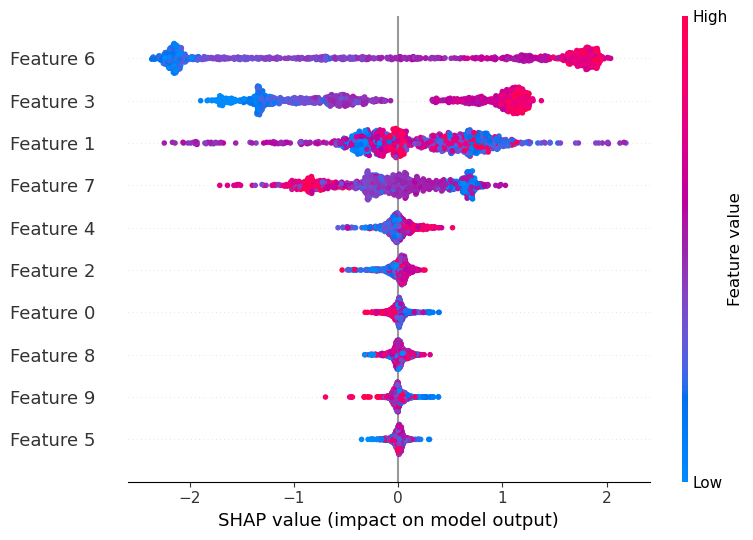

In [27]:
# Feature importance plot

shap.summary_plot(shap_values,X_test, feature_names = [f'Feature {i}' for i in range (X.shape[1])])